In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV, LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import bootstrap
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze
from mrmr import mrmr_classif, mrmr_regression
import sys
from io import StringIO

In [12]:
# None-image features
data = getDataPandas()
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

# Tasks include models used
TASKS = [
    'classification/5'
]
# Features include image features used
FEATURES = [
    ['tiv_gmv', 't1_radiomic'],
]

# Maybe write to a specific file later?
log_func = print
rst = {}
auc_dist = {}

Current Task: classification/5

Image Features:
 ['tiv_gmv', 't1_radiomic']

SEX chi2 p: 0.5772326031544939
AGE_AT_VISIT Normaltest p_train: [0.05740598], p_test: [0.48166696]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([-0.05537471]), pvalue=array([0.95589089]))
NUPDR3OF Normaltest p_train: [0.01895273], p_test: [0.05125505]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.09049255]), pvalue=array([0.92789581]))
LEDD Normaltest p_train: [4.6194767e-12], p_test: [0.31716459]
LEDD ranksums p: RanksumsResult(statistic=array([0.45113199]), pvalue=array([0.65189442]))
DURATION Normaltest p_train: [0.00273752], p_test: [0.32684127]
DURATION ranksums p: RanksumsResult(statistic=array([-0.46177817]), pvalue=array([0.64424041]))



100%|██████████| 50/50 [00:01<00:00, 28.30it/s]


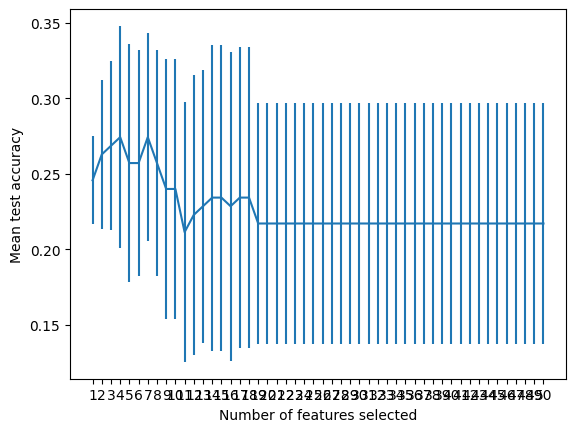

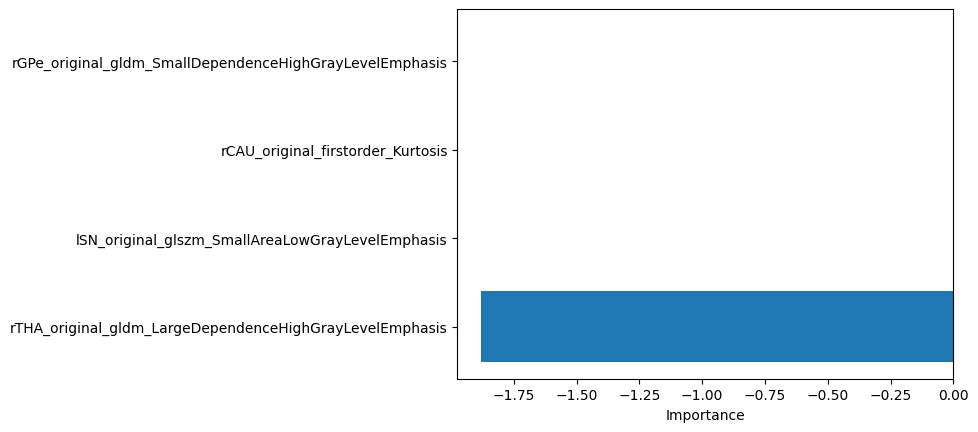

Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'lSN_original_glszm_SmallAreaLowGrayLevelEmphasis'
 'rCAU_original_firstorder_Kurtosis'
 'rGPe_original_gldm_SmallDependenceHighGrayLevelEmphasis']

Demo + Clinic:

Model: svc


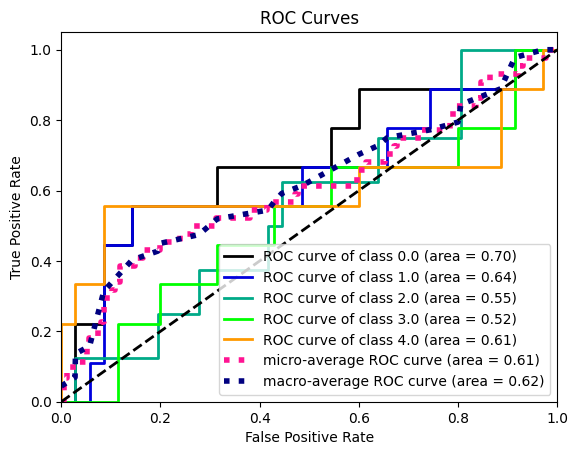

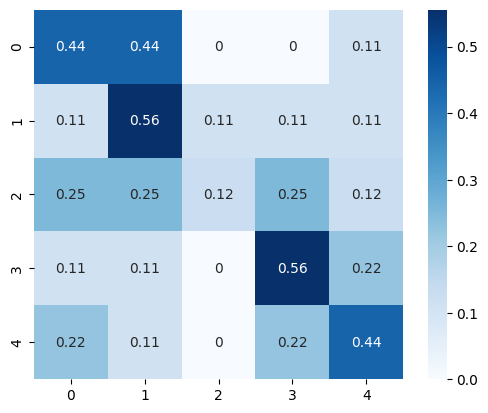

Model: xgboost


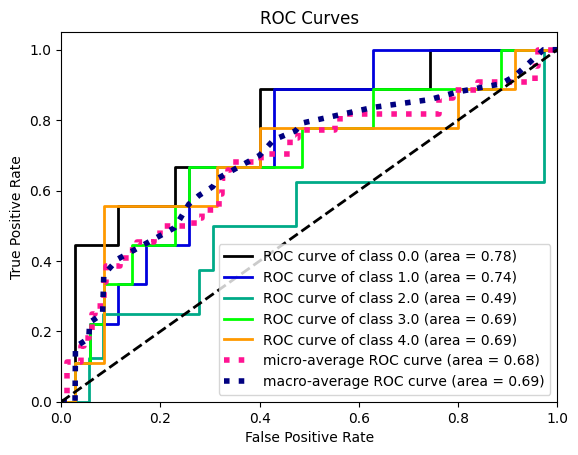

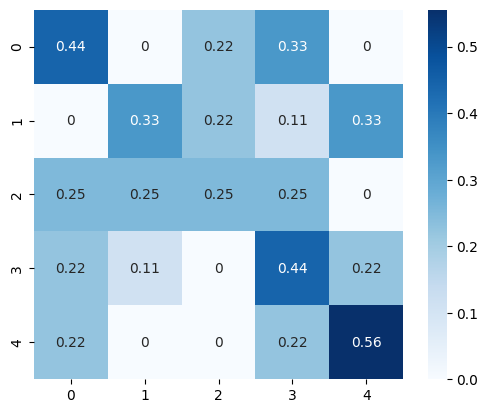


Demo + Clinic + Img:

Model: svc


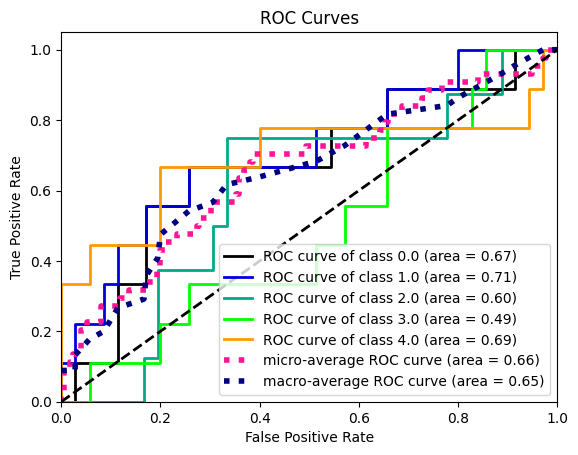

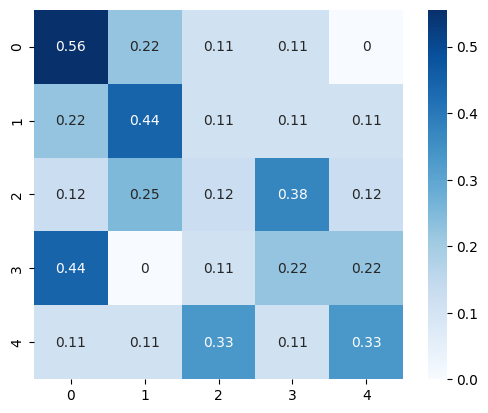

Model: xgboost


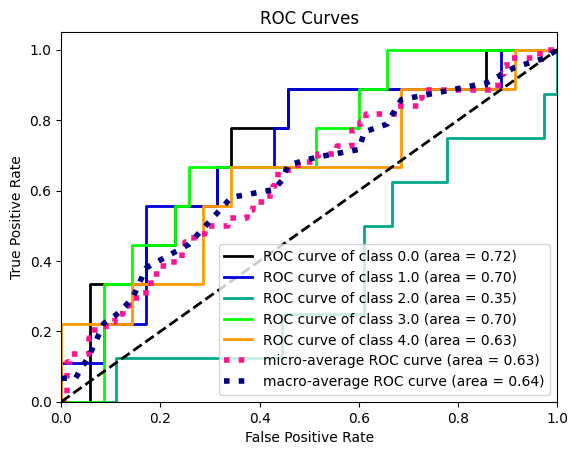

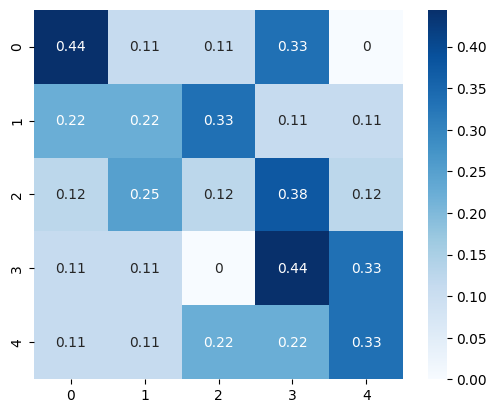

In [14]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_cat5_index']
        test_inds = data_config['test_cat5_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        # Normalization
        scaler = MinMaxScaler()
        x_img_train = pd.DataFrame(scaler.fit_transform(x_img_train, y_train), columns=x_img_train.columns)
        x_img_test = pd.DataFrame(scaler.transform(x_img_test), columns=x_img_test.columns)
        
        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        ##mRMR
        selected = mrmr_classif(X=x_img_train, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        ##LASSO for classification?
        # la = LassoCV(cv=5, random_state=1, max_iter=10000)
        # la.fit(x_img_train[selected], y_train)
        # print(la.alpha_)
        # plt.semilogx(la.alphas_, la.mse_path_, ':')
        # plt.plot(
        #     la.alphas_ ,
        #     la.mse_path_.mean(axis=-1),
        #     "k",
        #     label="Average across the folds",
        #     linewidth=2,
        # )
        # plt.axvline(
        #     la.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
        # )
        # plt.legend()
        # plt.ylabel('MSE')
        # plt.xlabel('alpha')
        # plt.show()
        # la = Lasso(alpha=la.alpha_)
        # la.fit(x_img_train[selected], y_train)
        # selected = np.array(selected)[np.abs(la.coef_)>0]
        # coef = np.array(la.coef_)[np.abs(la.coef_)>0]
        # sort_idx = coef.argsort()
        # plt.barh(selected[sort_idx], coef[sort_idx])
        # plt.xlabel('Importance')
        # plt.show()
        #selected = selected[:2]
        
        #est = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, l1_ratio=0.5)
        est = LogisticRegression(penalty='l1', solver='saga', random_state=1)
        #est = LogisticRegression(random_state=1)
        selector = RFECV(est, min_features_to_select=1, cv=5, step=1)
        selector = selector.fit(X=x_img_train[selected], y=y_train)
        selected = np.array(selected)[selector.get_support()]
        n_scores = len(selector.cv_results_["mean_test_score"])
        plt.errorbar(
            range(1, n_scores+1),
            selector.cv_results_["mean_test_score"],
            yerr=selector.cv_results_["std_test_score"],
        )
        plt.xticks(range(1,n_scores+1))
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean test accuracy")
        plt.show()
        coef = selector.estimator_.coef_[0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        #selector = selector.fit(X=x_img_train, y=y_train)
        #selected = np.array(x_img_train.columns)[selector.get_support()]

        
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']
        
        #x_train_list = [x_clinic_img_train]
        #x_test_list = [x_clinic_img_test]
        #info_list = ['Demo + Clinic + Img:']
        
        #selected = ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis']

        # Loop
        for i in range(len(info_list)):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            scaler = MinMaxScaler()
            x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
            x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]
                cv = GridSearchCV(
                    model(),
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring']
                )

                cv.fit(x_train, y_train.values.ravel())
                model_instance = model(**cv.best_params_)
                model_instance.fit(x_train, y_train.values.ravel())
                
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = model_instance.predict_proba if metric[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)

                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = model_instance.predict_proba if plot[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
            log_func()